In [2]:
import argparse, os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

### multi processing
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing as mp
####

import data.HCP_dataset_h5
import data.utils_metrics as utils_met
from itertools import product
from deep_cascade_caunet.models import CSEUnetModel
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import utils
import data.HCP_dataset_h5 as HCP_dataset

import math
import torch.nn.functional as F

number of common Subjects  171


In [3]:
def pad(x):
        _, _, h, w = x.shape
        w_mult = ((w - 1) | 15) + 1
        h_mult = ((h - 1) | 15) + 1
        w_pad = [math.floor((w_mult - w) / 2), math.ceil((w_mult - w) / 2)]
        h_pad = [math.floor((h_mult - h) / 2), math.ceil((h_mult - h) / 2)]
        #print(w_pad,h_pad)
        # # TODO: fix this type when PyTorch fixes theirs
        # # the documentation lies - this actually takes a list
        # # https://github.com/pytorch/pytorch/blob/master/torch/nn/functional.py#L3457
        # # https://github.com/pytorch/pytorch/pull/16949
        x = F.pad(x, w_pad + h_pad)
        return x, (h_pad, w_pad, h_mult, w_mult)

def unpad(x,h_pad,w_pad,h_mult,w_mult):
    return x[..., h_pad[0] : h_mult - h_pad[1], w_pad[0] : w_mult - w_pad[1]]

def resize(data):
    x,y = [],[]
    for i in range(len(data)):
        x.append(data[i][0].reshape((data[i][0].shape[0]*data[i][0].shape[1],data[i][0].shape[2],data[i][0].shape[3])))
        y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
    return torch.from_numpy(np.stack(x)),torch.from_numpy(np.stack(y))


In [4]:

parser = argparse.ArgumentParser(description="IMDN")
parser.add_argument("--block_size", type=tuple, default=(64,64,64),
                    help="Block Size")
parser.add_argument("--crop_depth", type=int, default=30,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="")
parser.add_argument("--sort", type=bool,
                    help="")
parser.add_argument("--debug", type=bool,
                    help="")
parser.add_argument("--preload", type=bool,
                    help="")
args = list(parser.parse_known_args())[0]
args.preload = True
args.debug = False
args.dir = "/storage"
args.batch_size = 4
args.sort = True
args.typ = 'upsampled'
args.block_size = (64,64,64)
args.epochs = 100
print(args)


args.cuda = True
cuda = args.cuda
device = torch.device('cuda' if cuda else 'cpu')

ids = utils.get_ids()
ids.sort()
ids = ids[:80]
dataset_hcp = HCP_dataset
dataset_hcp.load_data(args.dir,ids)
testing_dataset = dataset_hcp.hcp_data_test(args,ids[:10])
testing_data_loader = DataLoader(dataset=testing_dataset, batch_size=1,pin_memory=True,collate_fn=resize,shuffle = True)


Namespace(batch_size=4, block_size=(64, 64, 64), crop_depth=30, debug=False, dir='/storage', epochs=100, preload=True, sort=True, typ='upsampled')


In [5]:
training_dataset = dataset_hcp.hcp_data(args,ids[10:15])
training_data_loader = DataLoader(dataset=training_dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)

In [6]:
model = CSEUnetModel(in_chans = 8,out_chans = 5,chans = 4,num_pool_layers = 2,drop_prob=0.2,reduction=4)

In [7]:
!ls checkpoint_skip_blank

CSEUnetModel_ssim0.05,psnr12.10.pth   CSEUnetModel_ssim26.64,psnr19.72.pth
CSEUnetModel_ssim0.10,psnr6.46.pth    CSEUnetModel_ssim26.66,psnr16.93.pth
CSEUnetModel_ssim0.11,psnr8.07.pth    CSEUnetModel_ssim26.69,psnr17.31.pth
CSEUnetModel_ssim0.11,psnr8.31.pth    CSEUnetModel_ssim26.70,psnr18.97.pth
CSEUnetModel_ssim0.13,psnr9.61.pth    CSEUnetModel_ssim26.70,psnr19.56.pth
CSEUnetModel_ssim0.23,psnr11.22.pth   CSEUnetModel_ssim26.71,psnr16.45.pth
CSEUnetModel_ssim0.26,psnr8.61.pth    CSEUnetModel_ssim26.71,psnr16.92.pth
CSEUnetModel_ssim0.64,psnr10.25.pth   CSEUnetModel_ssim26.78,psnr17.70.pth
CSEUnetModel_ssim0.72,psnr8.40.pth    CSEUnetModel_ssim26.79,psnr20.35.pth
CSEUnetModel_ssim0.79,psnr9.09.pth    CSEUnetModel_ssim26.80,psnr19.19.pth
CSEUnetModel_ssim0.96,psnr9.46.pth    CSEUnetModel_ssim26.80,psnr20.16.pth
CSEUnetModel_ssim1.19,psnr9.87.pth    CSEUnetModel_ssim26.81,psnr17.35.pth
CSEUnetModel_ssim1.25,psnr16.42.pth   CSEUnetModel_ssim26.83,psnr20.19.pth
CSEUnetModel_ssim1.43,psn

In [8]:
model.load_state_dict(torch.load("checkpoint_skip_blank/CSEUnetModel_ssim77.08,psnr21.61.pth"))

<All keys matched successfully>

In [9]:
model = model.to('cuda')
out_size = (32,64,64,64, 5)

In [10]:

import data.utils_metrics as utils_met
HR = {}
predictions = {}
LR = {}
psnr = {}
ssim = {}
counter = 0
for batch in training_data_loader:
    lr_tensor, hr_tensor = batch[0], batch[1]
    if args.cuda:
        lr_tensor = lr_tensor.to(device)
        hr_tensor = hr_tensor.to(device)
    lr_tensor = torch.permute(lr_tensor,(0,3,1,2))
    LR[counter] = lr_tensor
    temp = pad(lr_tensor)

    with torch.no_grad():
        # print(lr_tensor.shape)
        pre = model(temp[0])

    pred = unpad(pre,temp[1][0],temp[1][1],temp[1][2],temp[1][3])
    pred = pred.reshape(out_size)
    predictions[counter] = pred
#     psnr[counter] = utils_met.compute_psnr(hr_tensor, pred)
#     ssim[counter] = utils_met.compute_ssim(hr_tensor, pred)
    HR[counter] = hr_tensor
    counter+=1

    

In [11]:
HR[0].max(),HR[0].min()

(tensor(1.0000, device='cuda:0', dtype=torch.float64),
 tensor(0., device='cuda:0', dtype=torch.float64))

In [12]:
predictions[0].max(),predictions[0].min()

(tensor(0.6922, device='cuda:0'), tensor(-0.2102, device='cuda:0'))

In [13]:
import cupy as cp
import cucim.skimage.metrics as metrics
hr = HR[0]
pred = (HR[0].cpu() - predictions[0].cpu())
hr = cp.array(hr.squeeze())
pred = cp.array(pred.squeeze())

In [14]:
hr.shape,pred.shape

((32, 64, 64, 64, 5), (32, 64, 64, 64, 5))

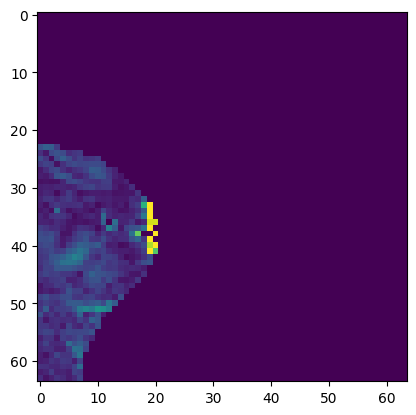

In [15]:
plt.imshow(hr[2,:,:,20,0].get())

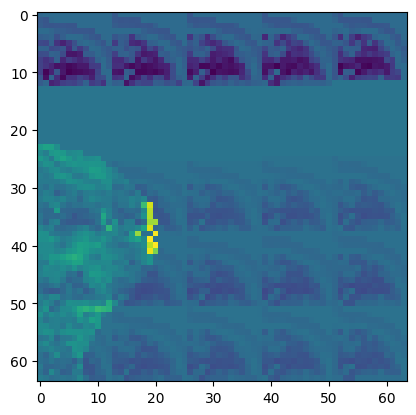

In [16]:
plt.imshow(pred[2,:,:,20,0].get())

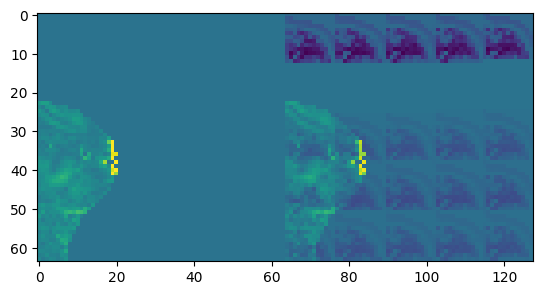

In [17]:
plt.imshow(np.concatenate((hr[2,:,:,20,0].get(),pred[2,:,:,20,0].get()),axis =1))

In [18]:
metrics.structural_similarity(hr,pred,channel_axis =4,data_range=1)

array(0.30011481)

In [19]:
metrics.peak_signal_noise_ratio(hr,pred,data_range=1)

array(18.63899233)

In [20]:
psnr.values()

dict_values([])

In [21]:
ssim.values()

dict_values([])

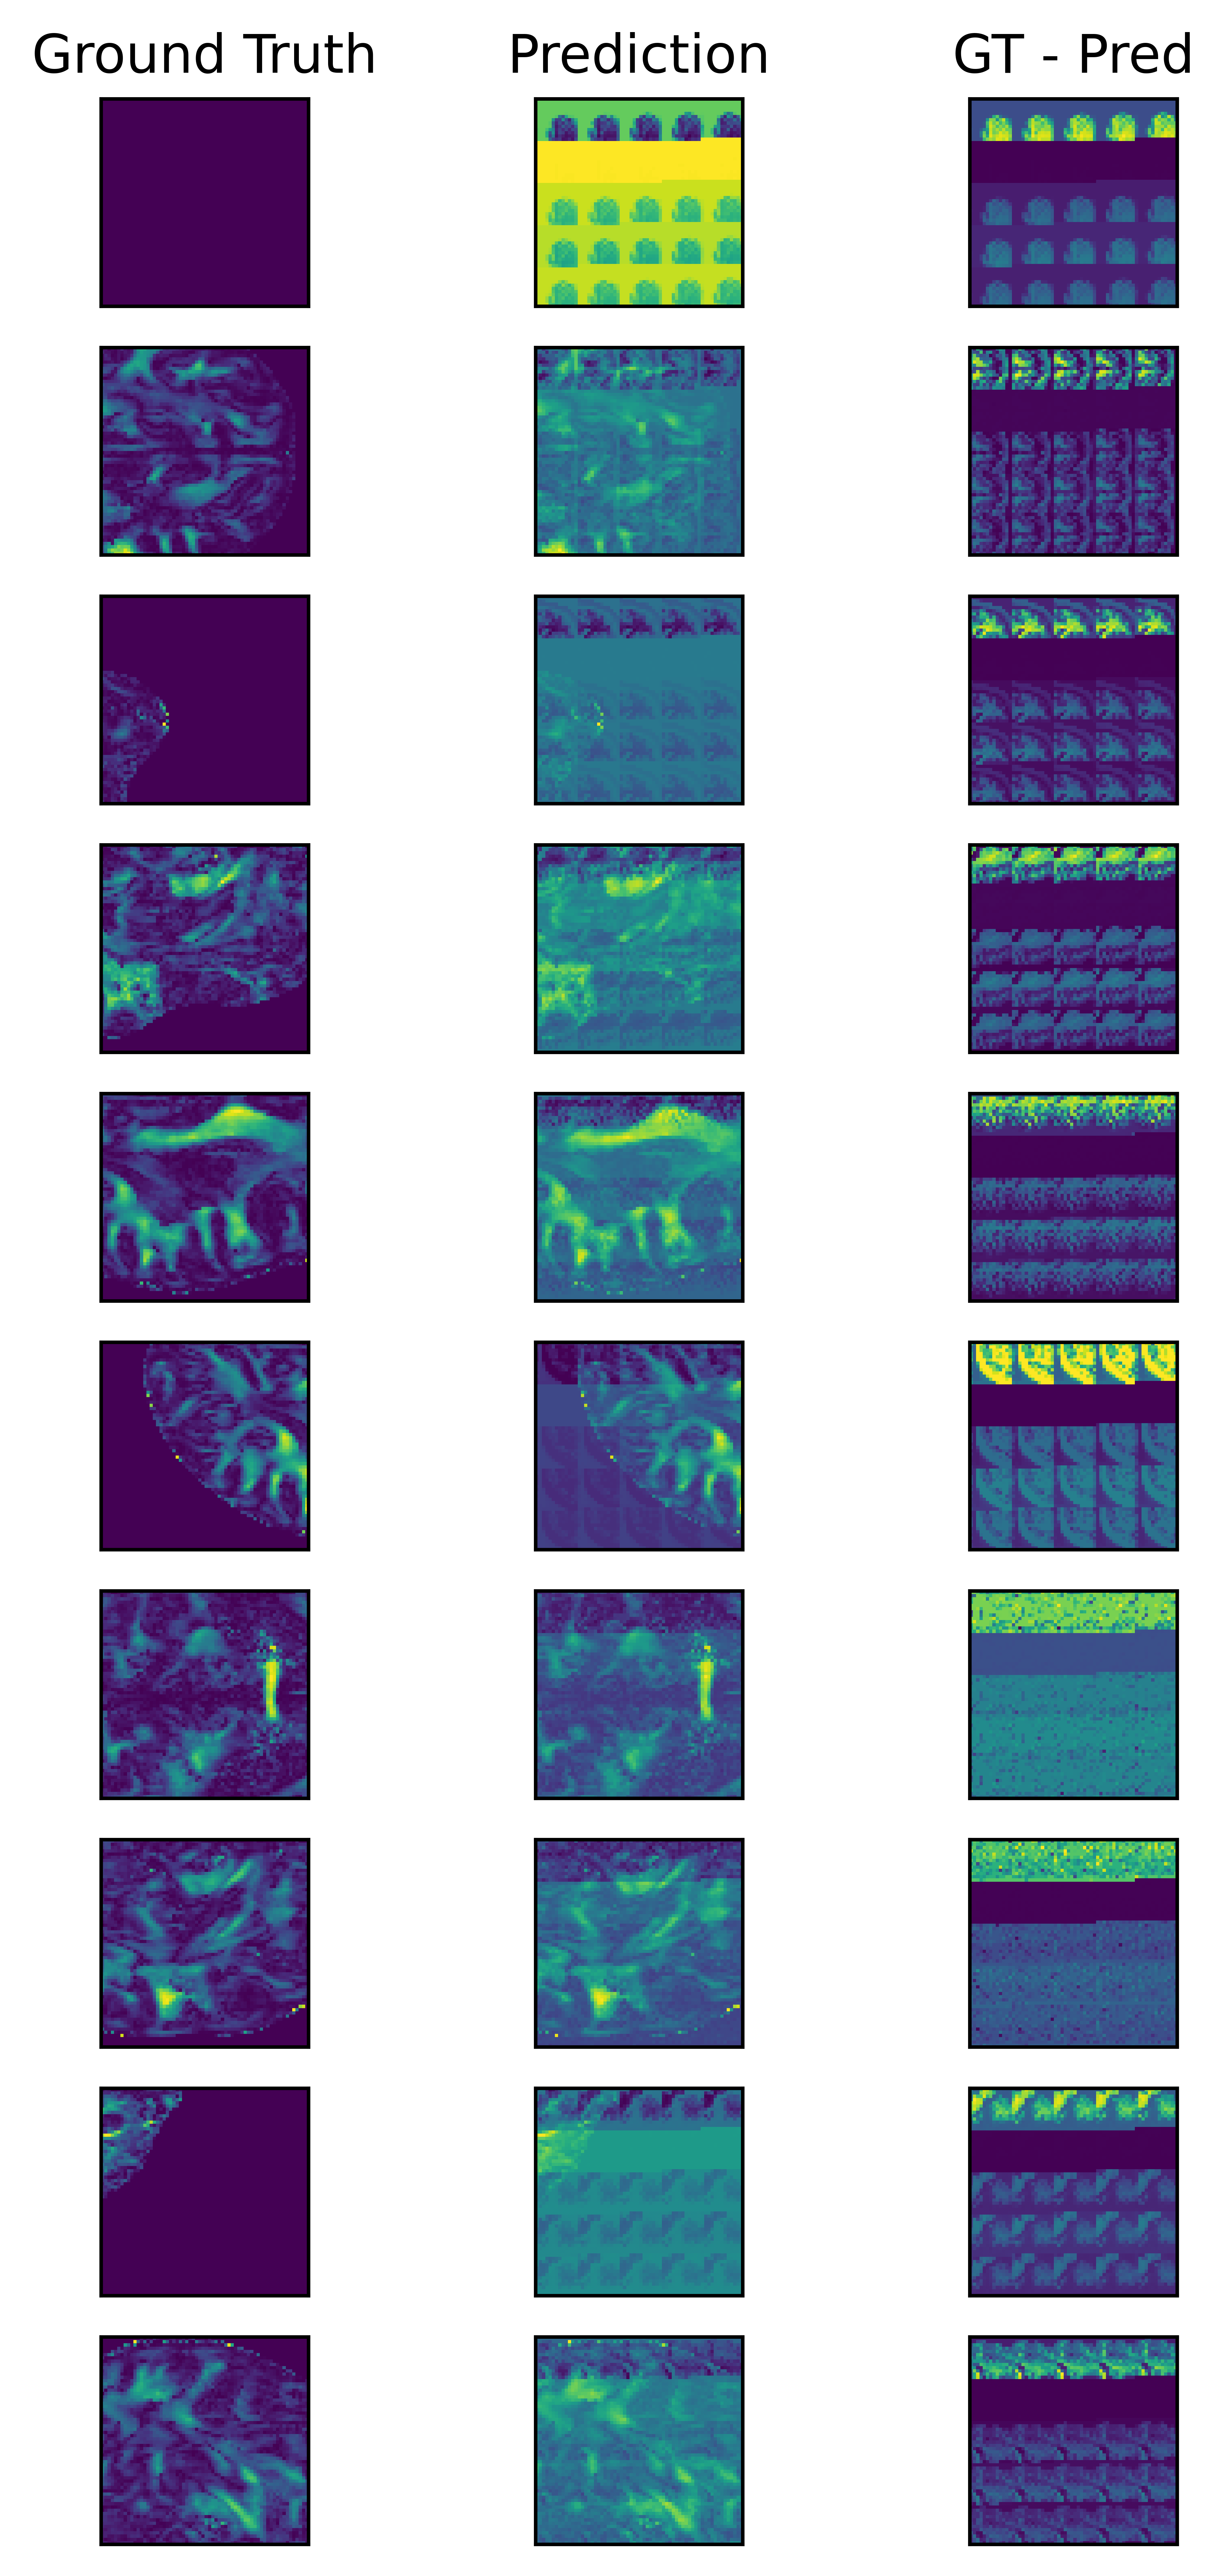

In [22]:
import matplotlib.pyplot as plt
import numpy as np
l = 10
f, axarr = plt.subplots(l,3)
f.set_figwidth(5)
f.set_figheight(l)
f.set_figsize= (8,6)
f.dpi = 1000
for i in range(l):
    for j in range(3):
        axarr[i,j].xaxis.set_tick_params(labelbottom=False)
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
        axarr[i,j].yaxis.set_tick_params(labelleft=False)
axarr[0,0].set_title("Ground Truth")
axarr[0,1].set_title("Prediction")
axarr[0,2].set_title("GT - Pred")
sl=70
chanl = 2
for i in range(l):
    axarr[i,0].imshow(hr[i,:,:,20,chanl].get())
    axarr[i,1].imshow(pred[i,:,:,20,chanl].get())
    axarr[i,2].imshow(hr[i,:,:,20,chanl].get() - pred[i,:,:,20,chanl].get())